# Analysis of test set results for AMP Conference
TODO

In [1]:
from collections import defaultdict
import json
from pathlib import Path
import regex as re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None



In [2]:
plt.rcParams["figure.figsize"] = (12, 12)
EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
TRAINED_MODEL_PATH = Path("../data/models/")

# Results from external baselines
EXTERNAL_PREDICTION_CSVS = [
    EVAL_PATH / "allosaurus_eng2102_eng_detailed_predictions.csv",
    EVAL_PATH
    / "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
]
EXTERNAL_NAME_PATTERN = re.compile(r"[\w-\.]+(?=_detailed_predictions.csv)")

EXPERIMENT_PREDICTION_CSVS = list(
    EVAL_PATH.glob("data_models_*_detailed_predictions.csv")
) + list(EVAL_PATH.glob("ginic_*_detailed_predictions.csv"))
EXPERIMENT_PREDICTION_CSVS = [file for file in EXPERIMENT_PREDICTION_CSVS if "hyperparams" not in str(file)]
# Use to pull the experiment name and number id from the file name
EXP_NAME_PATTERN = re.compile(
    r"(?<=(data_models_)|(ginic_))[\w-]+(?=_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv)"
)

EXPERIMENT_GROUP_DESCRIPTIONS = {
    # Models were trained/fine-tuned on 4000 samples unless otherwise noted
    "data_seed": "Our AutoIPA: balanced gender",
    "gender_split_0_female": "Our AutoIPA: only male speakers",
    "gender_split_30_female": "Our AutoIPA: biased male",
    "gender_split_70_female": "Our AutoIPA: biased female",
    "gender_split_100_female": "Our AutoIPA: only female speakers",
    "vary_individuals_young_only": "Our AutoIPA: biased young",
    "vary_individuals_old_only": "Our AutoIPA: biased old",
    "full_dataset_train": "Our AutoIPA: fine-tuned on full train split",
}


In [3]:
def get_experiment_label(full_exp_name, pattern):
    """Parse out the experiment label from the file name
    Experiment label are some brief description (\w chars) followed by _ and a single digit

    Args:
        full_exp_name (str): Filename for experiment results, starts with 'data_model_" followed by the experiment label and ends with "_detailed_predictions.csv"

    Returns:
        str: full experiment label
    """
    experiment_id = pattern.search(full_exp_name)
    return experiment_id.group(0)

In [4]:
# Combine all CSV together
exp_group_display_key = "Experiment group"

all_dataframes = []
for csv in EXPERIMENT_PREDICTION_CSVS:
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXP_NAME_PATTERN)
    experiment_group = experiment_label[:-2]
    experiment_id = experiment_label[-1:]
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    if experiment_group.startswith("train_duration"):
        # I named the train duration experiments stupidly
        for count in [20000, 12800, 6400, 3200, 1600, 800, 400, 200, 100]:
            if experiment_group.startswith(f"train_duration_{count}"):
                dataframe[exp_group_display_key] = f"Our AutoIPA: fine-tuned on {count} samples"
                break
    else:
        for k, v in EXPERIMENT_GROUP_DESCRIPTIONS.items():
            if experiment_group.startswith(k):
                dataframe[exp_group_display_key] = v
                break

    dataframe["Model source"] = "Our AutoIPA"
    all_dataframes.append(dataframe)


for csv in EXTERNAL_PREDICTION_CSVS:
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXTERNAL_NAME_PATTERN)
    experiment_group = experiment_label
    experiment_id = 1
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    if experiment_label.startswith("allosaurus"):
        dataframe[exp_group_display_key] = "Allosaurus English"
        dataframe["Model source"] = "Allosaurus English"
    elif experiment_label.startswith("ctaguchi"):
        dataframe[exp_group_display_key] = "Taguchi et al. 2023"
        dataframe["Model source"] = "Taguchi et al. 2023"
    elif "whisper" in experiment_label:
        dataframe[exp_group_display_key] = "Whisper + Epitran"
        dataframe["Model source"] = "Whisper + Epitran"
    else:
        dataframe[exp_group_display_key] = "Wav2Vec2.0 + Epitran"
        dataframe["Model source"] = "Wav2Vec2.0 + Epitran"

    all_dataframes.append(dataframe)

all_data = pd.concat(all_dataframes)
all_data.head()



data_models_train_duration_100_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_100_samples_5 Group: train_duration_100_samples Experiment id: 5
data_models_train_duration_800_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_800_samples_5 Group: train_duration_800_samples Experiment id: 5
data_models_train_duration_200_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_200_samples_4 Group: train_duration_200_samples Experiment id: 4
data_models_train_duration_12800_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_12800_samples_3 Group: train_duration_12800_samples Experiment id: 3
data_models_train_duration_3200_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_3200_samples_2 Group: train_duration_3200_samples Experiment id: 2
data_models_vary_individuals_old_only_3_wav2vec2-la

,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,...,phone_feature_error_rates,feature_error_rates,experiment_label,experiment_group,experiment_id,Experiment group,Model source,deletions,insertions,substitutions
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,...,5.000000,0.062500,train_duration_100_samples_5,train_duration_100_samples,5,Our AutoIPA: fine-tuned on 100 samples,Our AutoIPA,NaN,NaN,NaN
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,...,144.208333,0.187500,train_duration_100_samples_5,train_duration_100_samples,5,Our AutoIPA: fine-tuned on 100 samples,Our AutoIPA,NaN,NaN,NaN
2,s2501a_Utt2,22.609051,ah k ey U ah m ay tq w aa n n ah ch r ay dx uh...,okay VOCNOISE i might want to try to adjust th...,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌ...,S25,f,o,m,data/buckeye/test/s2501a_Utt2.wav,...,41.000000,0.216831,train_duration_100_samples_5,train_duration_100_samples,5,Our AutoIPA: fine-tuned on 100 samples,Our AutoIPA,NaN,NaN,NaN
3,s2501a_Utt3,2.279839,n aa t U ih tq ah z b eh dx er b ih f ao r,not LAUGH it was better before,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt3.wav,...,5.416667,0.346354,train_duration_100_samples_5,train_duration_100_samples,5,Our AutoIPA: fine-tuned on 100 samples,Our AutoIPA,NaN,NaN,NaN
4,s2501a_Utt4,0.410576,dh eh r,there,ðɛɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt4.wav,...,0.666667,0.201389,train_duration_100_samples_5,train_duration_100_samples,5,Our AutoIPA: fine-tuned on 100 samples,Our AutoIPA,NaN,NaN,NaN


# Overall model performance in aggregate
This section collects the test set performance results form all models to compare. 

The metrics we are using to measure model performance are described as follows and lower values indicate better performance for all of them: 
- **phone error rate**: Phone error rate (PER) gives edit distance in terms of phones for each prediction-reference pair, rather than Unicode characters, since phones can consist of multiple characters. It is normalized by the number of phones of the reference string. The result will have the same length as the input prediction and reference lists.
- **phone feature error rate**: Phone feature error rate (PFER) is Levenshtein distance between strings where distance between individual phones is computed using Hamming distance between phonetic features for each prediction-reference pair. By default it is a metric that obeys the triangle equality, but can also be normalized by number of phones.
- **feature error rate**: Feature error rate (FER) is the edit distance in terms of articulatory features normalized by the number of phones in the reference, computed for each prediction-reference pair.

## Summary of results
- All the models we've trained on Buckeye data perform better than external baselines, which include the [best model](https://huggingface.co/ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000) from the [Taguchi paper](http://arxiv.org/pdf/2308.03917), [Allosaurus](https://github.com/xinjli/allosaurus), and passing wav2vec2 output to the [Epitran](https://github.com/dmort27/epitran) grapheme to phoneme library. This is fairly unsurprising, given that we've fine-tuned our models on data that is more similar to the test set. However, it does demonstrate the benefit of fine-tuning in situations where low error rates are critically important. 
- There is little difference between the performance of our models, despite variation in the make up of training data. 

In [5]:
# Overall average error rates for each individual model
by_model_avg_metrics = (
    all_data.groupby(
        [
            "experiment_label", "experiment_group", exp_group_display_key, "Model source" #last 3 keys are added just so we don't have to join them in later
        ]
    )[["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]]
    .mean()
    .reset_index()
    .sort_values(by="phone_error_rates")
)
display(by_model_avg_metrics.head(10))

,experiment_label,experiment_group,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
43,train_duration_20000_samples_4,train_duration_20000_samples,Our AutoIPA: fine-tuned on 20000 samples,Our AutoIPA,0.252720,3.869372,0.158717
42,train_duration_20000_samples_3,train_duration_20000_samples,Our AutoIPA: fine-tuned on 20000 samples,Our AutoIPA,0.253557,3.846254,0.159487
30,train_duration_12800_samples_1,train_duration_12800_samples,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,0.254866,3.903163,0.158030
12,full_dataset_train_5,full_dataset_train,Our AutoIPA: fine-tuned on full train split,Our AutoIPA,0.256308,3.902466,0.157821
8,full_dataset_train_1,full_dataset_train,Our AutoIPA: fine-tuned on full train split,Our AutoIPA,0.257255,3.838879,0.158893
33,train_duration_12800_samples_4,train_duration_12800_samples,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,0.257684,3.936552,0.158598
32,train_duration_12800_samples_3,train_duration_12800_samples,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,0.257969,3.884516,0.158563
34,train_duration_12800_samples_5,train_duration_12800_samples,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,0.258357,3.921212,0.159332
11,full_dataset_train_4,full_dataset_train,Our AutoIPA: fine-tuned on full train split,Our AutoIPA,0.258789,3.935839,0.158900
40,train_duration_20000_samples_1,train_duration_20000_samples,Our AutoIPA: fine-tuned on 20000 samples,Our AutoIPA,0.259358,3.977391,0.159365


In [6]:
# Limit to only the best performing model in each group
best_experiment_in_group = (
    by_model_avg_metrics.groupby([exp_group_display_key, "Model source"])[
        ["experiment_label", "phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .first()
    .reset_index()
    .sort_values(by="phone_error_rates")
)

display(best_experiment_in_group)

,Experiment group,Model source,experiment_label,phone_error_rates,phone_feature_error_rates,feature_error_rates
10,Our AutoIPA: fine-tuned on 20000 samples,Our AutoIPA,train_duration_20000_samples_4,0.252720,3.869372,0.158717
7,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,train_duration_12800_samples_1,0.254866,3.903163,0.158030
15,Our AutoIPA: fine-tuned on full train split,Our AutoIPA,full_dataset_train_5,0.256308,3.902466,0.157821
13,Our AutoIPA: fine-tuned on 6400 samples,Our AutoIPA,train_duration_6400_samples_2,0.262291,3.984864,0.160182
2,Our AutoIPA: biased female,Our AutoIPA,gender_split_70_female_2,0.276478,4.231386,0.164055
1,Our AutoIPA: balanced gender,Our AutoIPA,data_seed_bs64_1,0.279805,4.259689,0.162166
3,Our AutoIPA: biased male,Our AutoIPA,gender_split_30_female_4,0.287317,4.390759,0.167159
4,Our AutoIPA: biased old,Our AutoIPA,vary_individuals_old_only_1,0.289996,4.449367,0.166510
5,Our AutoIPA: biased young,Our AutoIPA,vary_individuals_young_only_2,0.293123,4.402491,0.167726
11,Our AutoIPA: fine-tuned on 3200 samples,Our AutoIPA,train_duration_3200_samples_4,0.329461,4.828304,0.164365


In [7]:
model_type_means = (
    all_data.groupby([exp_group_display_key, "Model source"])[
        ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .mean()
    .reset_index()
    .sort_values(by="phone_error_rates")
)
display(model_type_means)


,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
10,Our AutoIPA: fine-tuned on 20000 samples,Our AutoIPA,0.258334,3.985757,0.159476
15,Our AutoIPA: fine-tuned on full train split,Our AutoIPA,0.259110,3.926513,0.159418
7,Our AutoIPA: fine-tuned on 12800 samples,Our AutoIPA,0.259346,3.954382,0.159228
13,Our AutoIPA: fine-tuned on 6400 samples,Our AutoIPA,0.264076,4.069735,0.160735
1,Our AutoIPA: balanced gender,Our AutoIPA,0.289700,4.370652,0.162465
2,Our AutoIPA: biased female,Our AutoIPA,0.292399,4.402909,0.166525
4,Our AutoIPA: biased old,Our AutoIPA,0.297602,4.465058,0.167044
5,Our AutoIPA: biased young,Our AutoIPA,0.299078,4.449676,0.167108
3,Our AutoIPA: biased male,Our AutoIPA,0.306236,4.517336,0.166410
11,Our AutoIPA: fine-tuned on 3200 samples,Our AutoIPA,0.337522,4.950842,0.166604


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_11433/397042138.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')


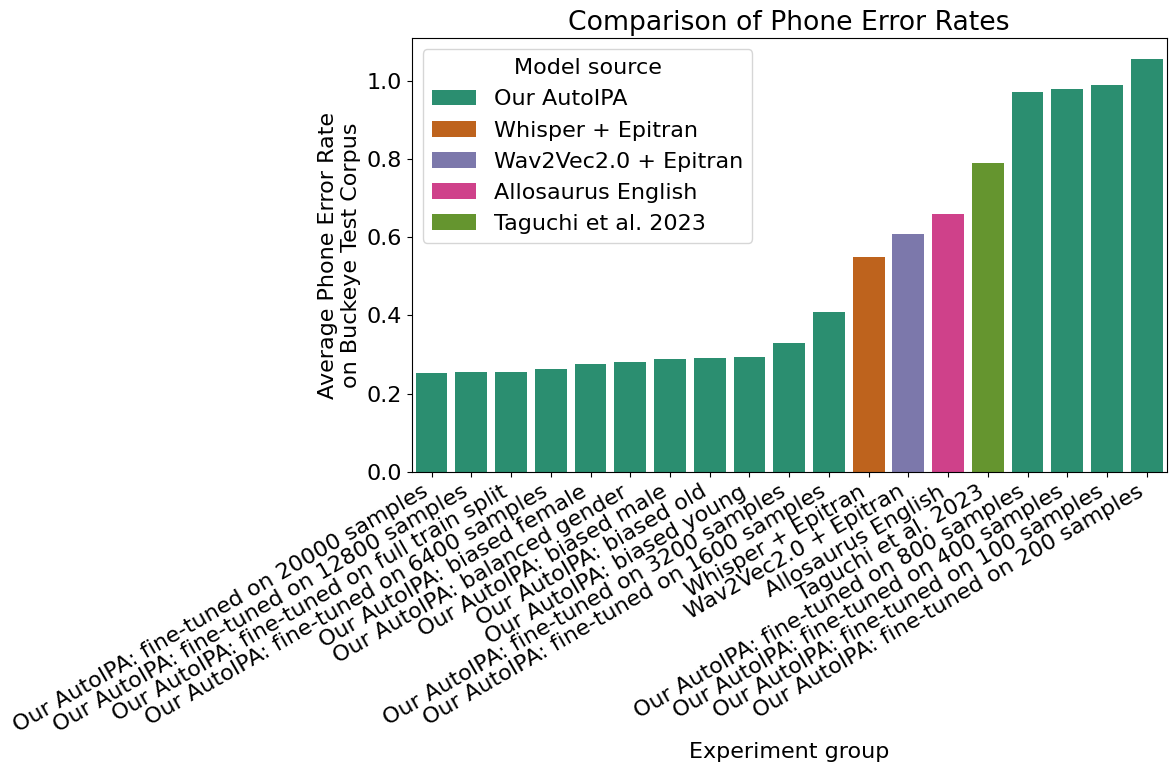

In [8]:
# Compare the average phone error rate for the best model in each group
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=best_experiment_in_group, x=exp_group_display_key, y="phone_error_rates", hue="Model source", palette="Dark2"
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_11433/1162270930.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


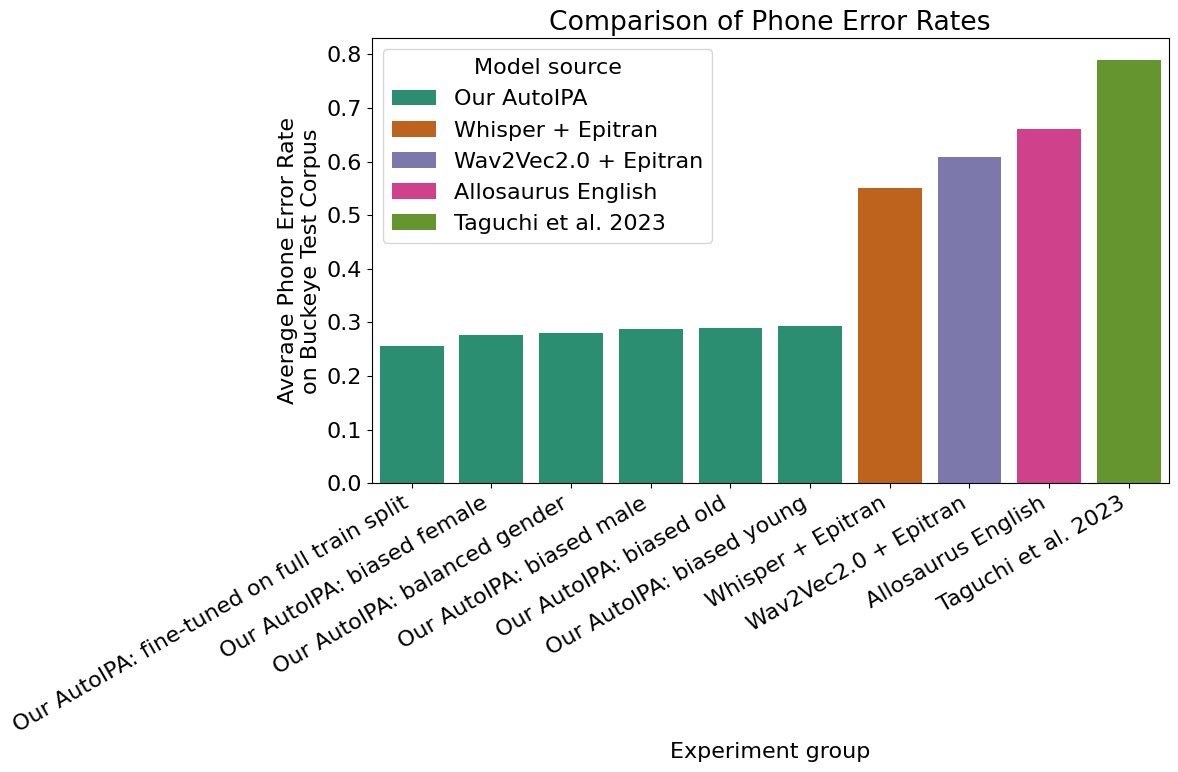

In [9]:
# Compare the average phone error rate for the best model in each group, but exclude 'train duration' experiments
best_models_no_train_duration = best_experiment_in_group[
    ~best_experiment_in_group["experiment_label"].str.startswith("train_duration")
]
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=best_models_no_train_duration,
    x=exp_group_display_key,
    y="phone_error_rates",
    hue="Model source",
    palette="Dark2",
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_11433/2730995564.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


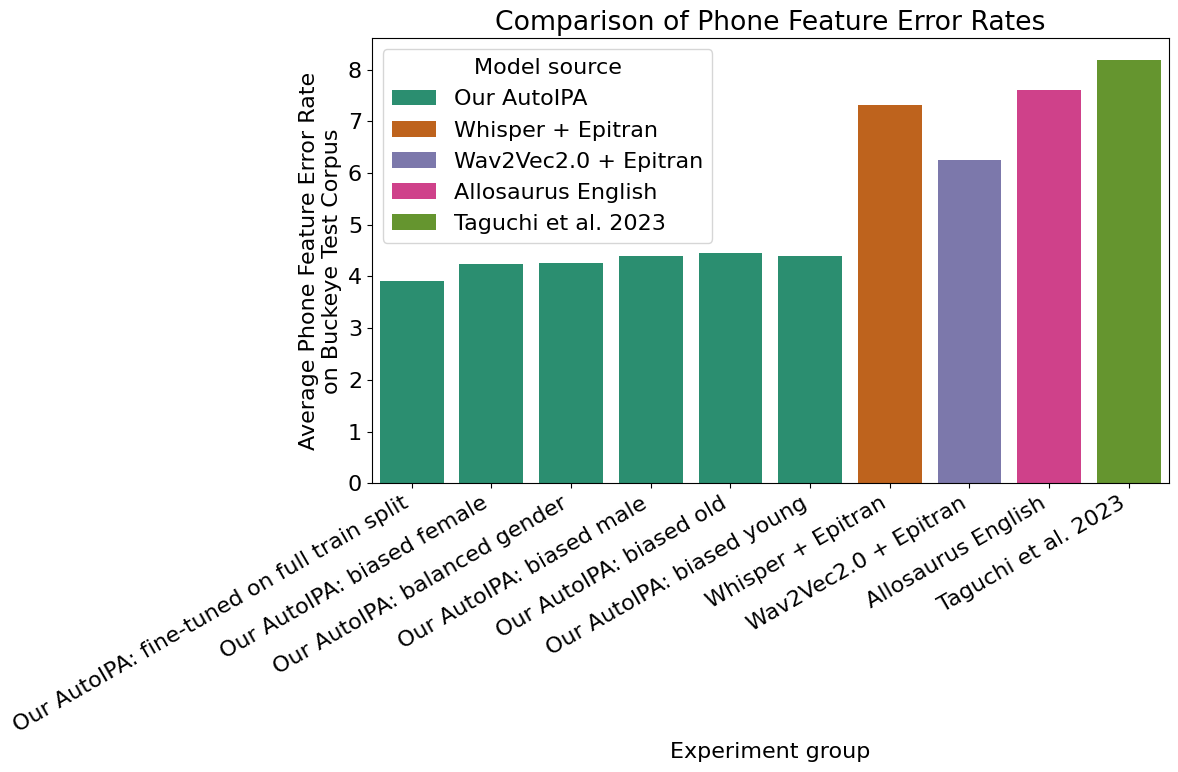

In [10]:
best_models_no_train_duration = best_experiment_in_group[
    ~best_experiment_in_group["experiment_label"].str.startswith("train_duration")
]
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=best_models_no_train_duration,
    x=exp_group_display_key,
    y="phone_feature_error_rates",
    hue="Model source",
    palette="Dark2",
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Feature Error Rates")
g.set_ylabel("Average Phone Feature Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_11433/3548242210.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


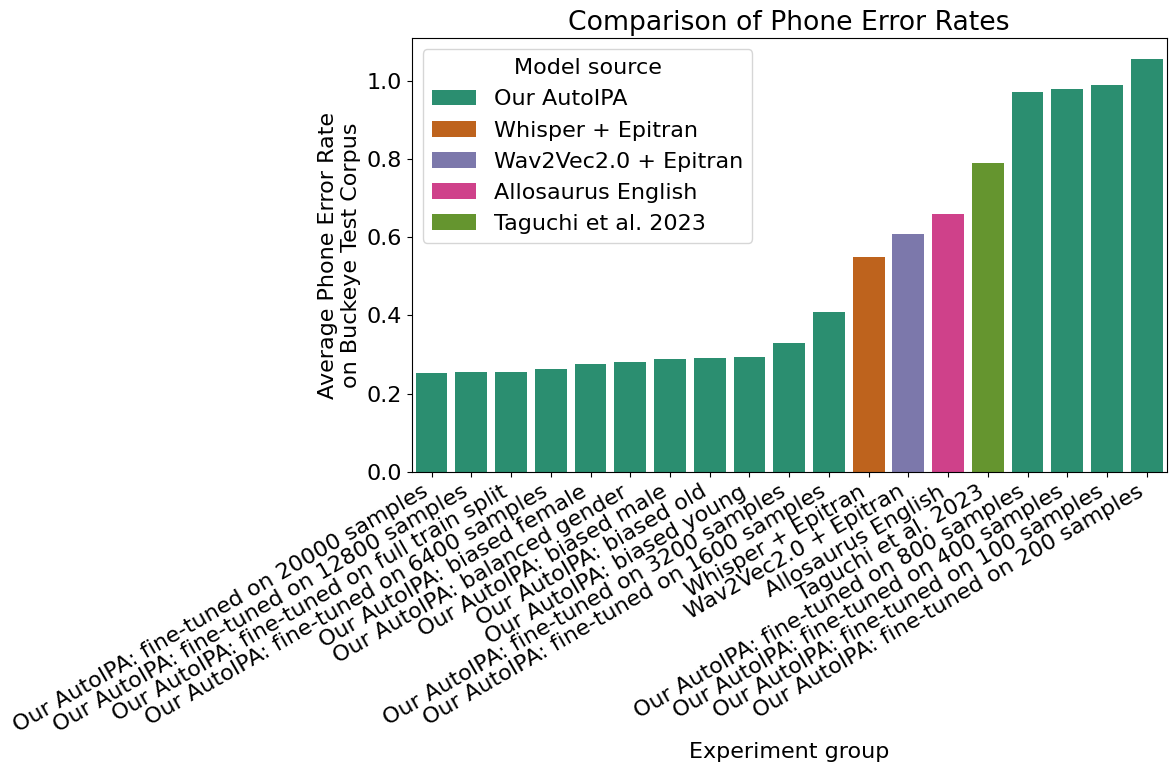

In [11]:
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=best_experiment_in_group, x=exp_group_display_key, y="phone_error_rates", hue="Model source", palette="Dark2"
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


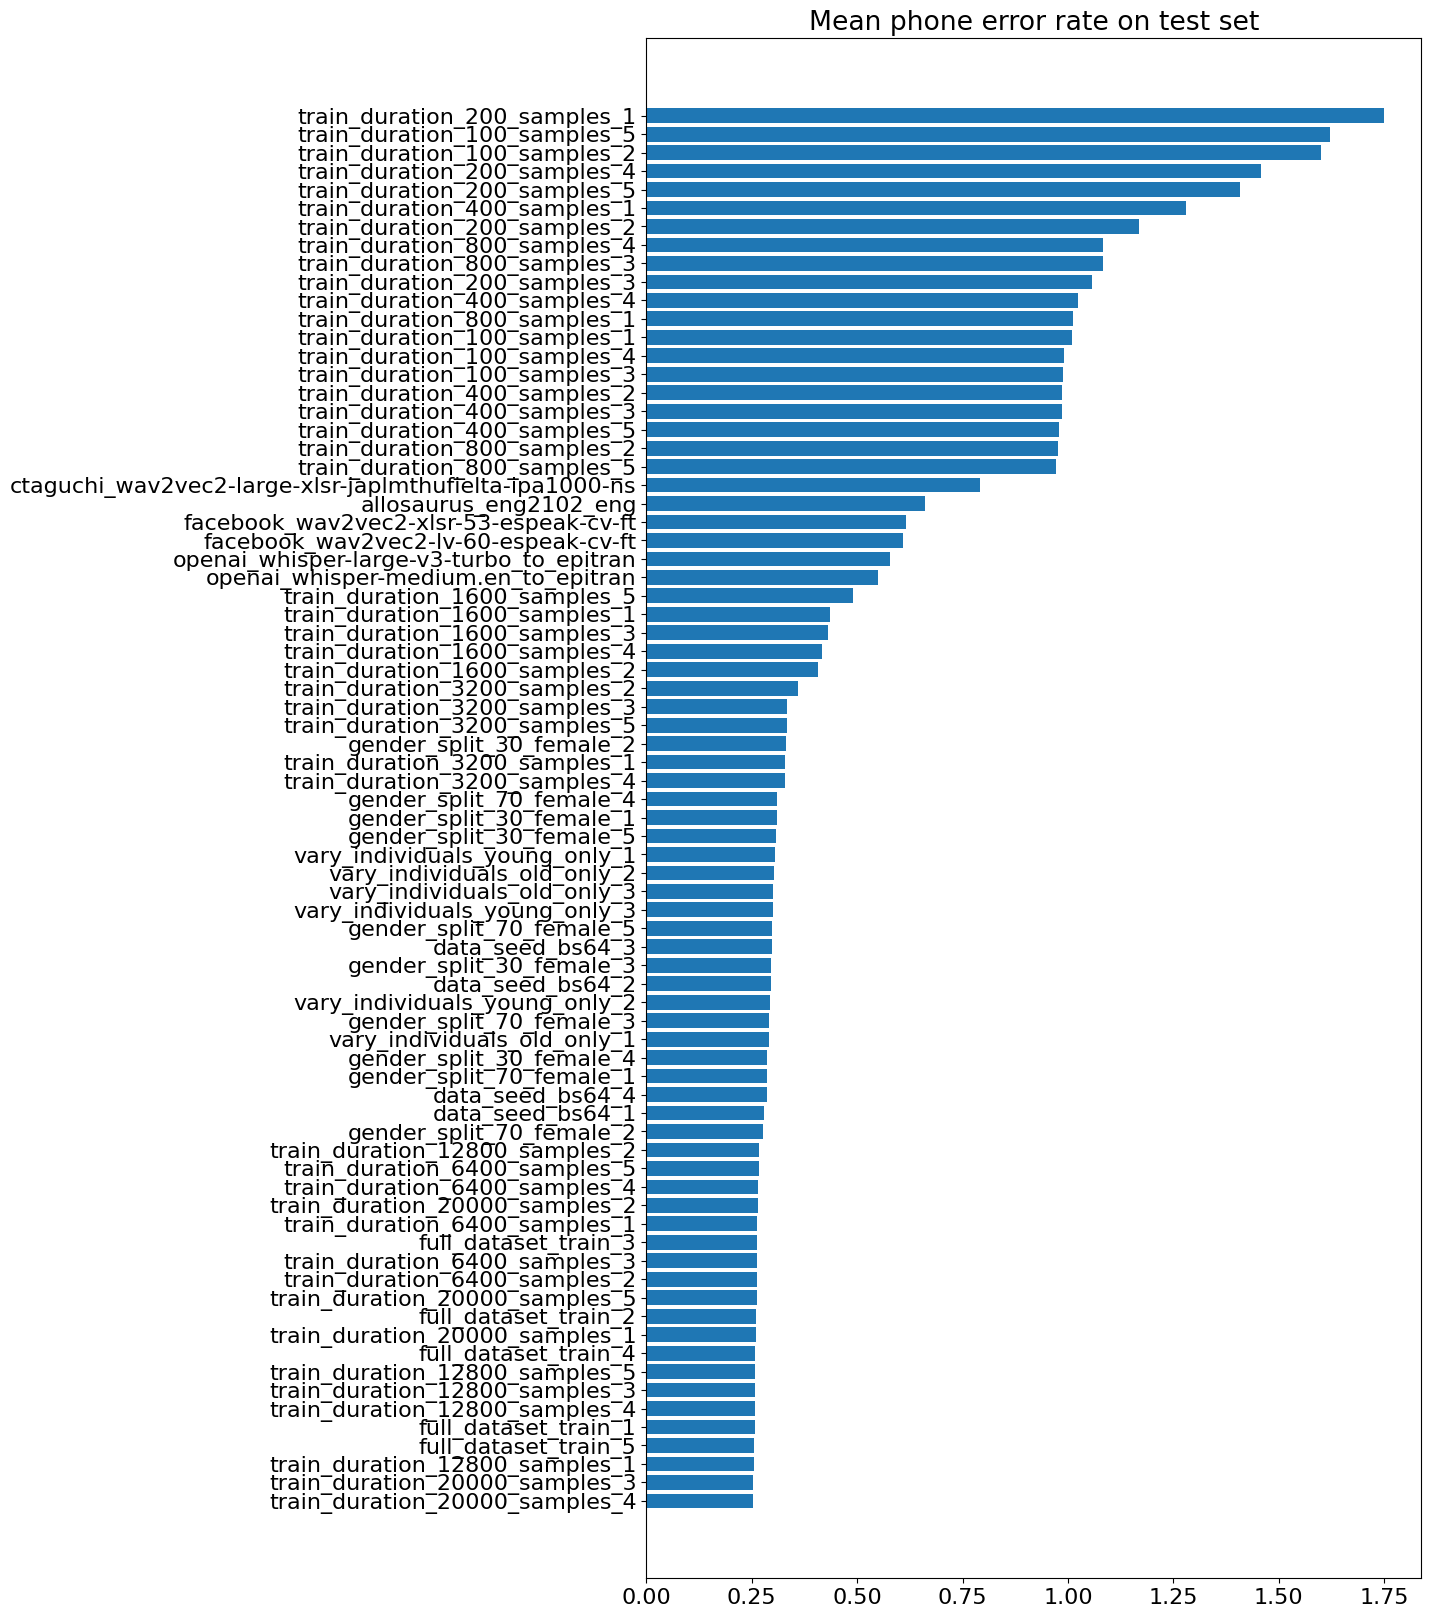

In [12]:
fig, ax = plt.subplots(figsize=(10, 20)) # Change the height here
ax.barh(by_model_avg_metrics["experiment_label"], by_model_avg_metrics["phone_error_rates"])
_ = ax.set_title("Mean phone error rate on test set")

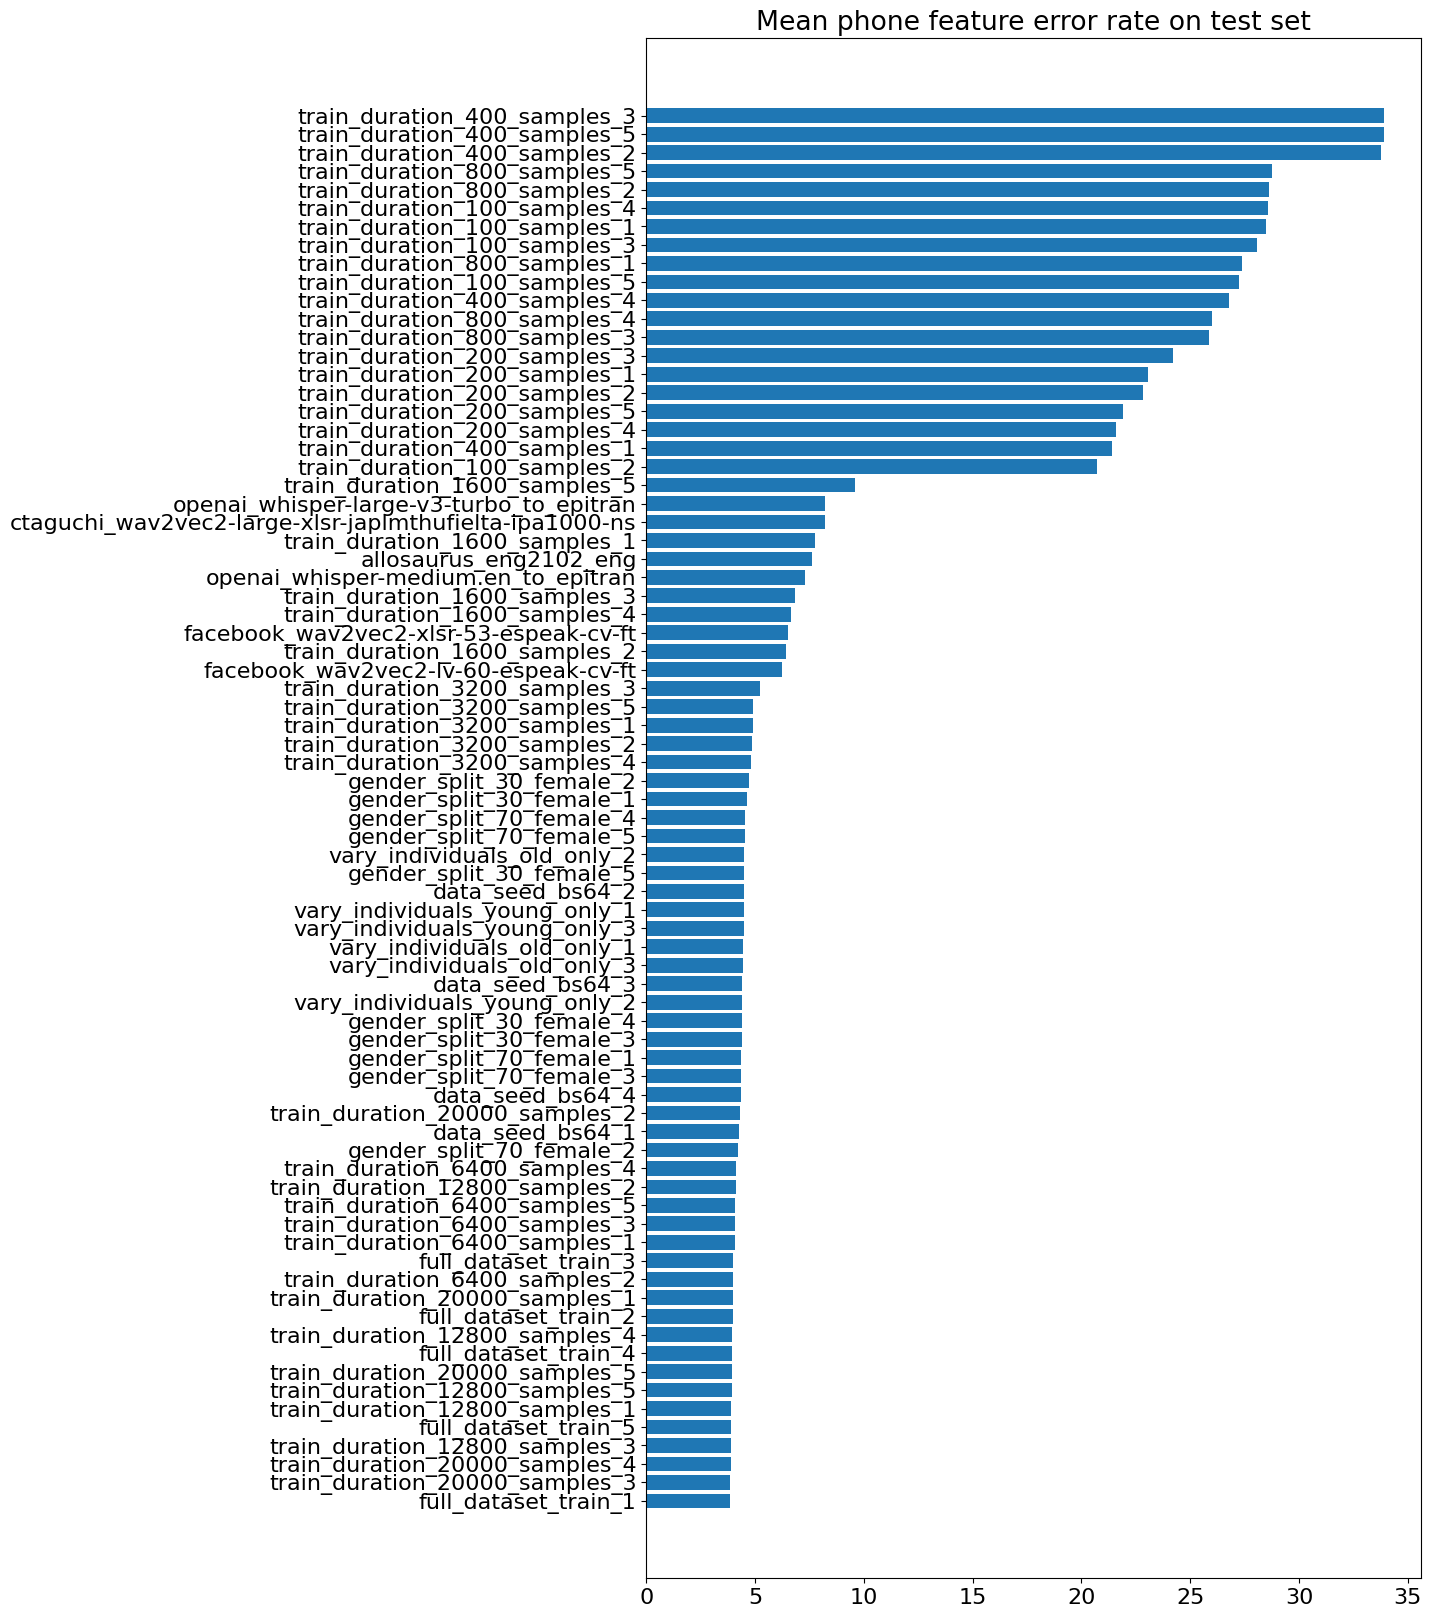

In [13]:

by_model_avg_metrics.sort_values(by="phone_feature_error_rates", inplace=True)
fig, ax = plt.subplots(figsize=(10, 20))
ax.barh(by_model_avg_metrics["experiment_label"], by_model_avg_metrics["phone_feature_error_rates"])
_ = ax.set_title("Mean phone feature error rate on test set")

# Differences in performance by gender
This looks at the differences in performance in samples from for male and female speakers in the test set. 
Across the board, the models (both our fine-tuned and the external baselines) perform better on female speakers than male speakers. This is not due to the duration of speakers of a specific gender appearing in the training data, because performance metrics are higher for female speakers even when 70% of training data samples came from male speakers and the duration of training data from male speakers was larger than the duration of training samples from female speakers. 

Note that it is yet unclear whether these performance differences are statistically significance. That requires further discussion of experimental design and desired research goals. 

In [14]:
def stratify_mean_by_experiment_group_and_demographic(dataframe, experiment_label_key = "experiment_label", demo_key="speaker_gender"):
    stratified_metrics = defaultdict(lambda: defaultdict(list)) # e.g. for gender {'m':{'phone_error_rate':[...]}, 'f':{'phone_error_rate':[...]}}
    models = list()
    for name, model_group in dataframe.groupby(experiment_label_key):
        for demo, group in model_group.groupby(demo_key):
            for metric in ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]:
                metric_mean = group[metric].mean()
                stratified_metrics[demo][metric].append(metric_mean)
        models.append(name)

    return stratified_metrics, models


In [15]:
gendered_metrics, models = stratify_mean_by_experiment_group_and_demographic(all_data)

In [16]:
# Check that these are all the same length to make sure we parsed data correctly
assert len(gendered_metrics['f']['phone_error_rates']) == len(gendered_metrics['m']['phone_error_rates'])
assert len(gendered_metrics['f']['phone_error_rates']) == len(models)

In [17]:
def plot_binary_category_grouped_metrics(models, category1_results_dict, category2_results_dict, title="Average phone error rate by gender", metric_name ="phone_error_rates",
        category1_label="male speaker", category2_label="female speaker"):
    category1_per = category1_results_dict[metric_name]
    category2_per = category2_results_dict[metric_name]
    assert len(category1_per) == len(models)
    assert len(category2_per) == len(models)

    fig, ax = plt.subplots()
    y = np.arange(len(models))
    width = 0.3
    multiplier = 0

    plt.barh(y-width, category1_per, width)
    plt.barh(y,  category2_per, width)
    plt.yticks(y, models)
    plt.ylabel("experiment label")
    plt.xlabel(metric_name)
    plt.title(title)
    plt.legend([category1_label, category2_label],loc='center left', bbox_to_anchor=(1, 0.5))

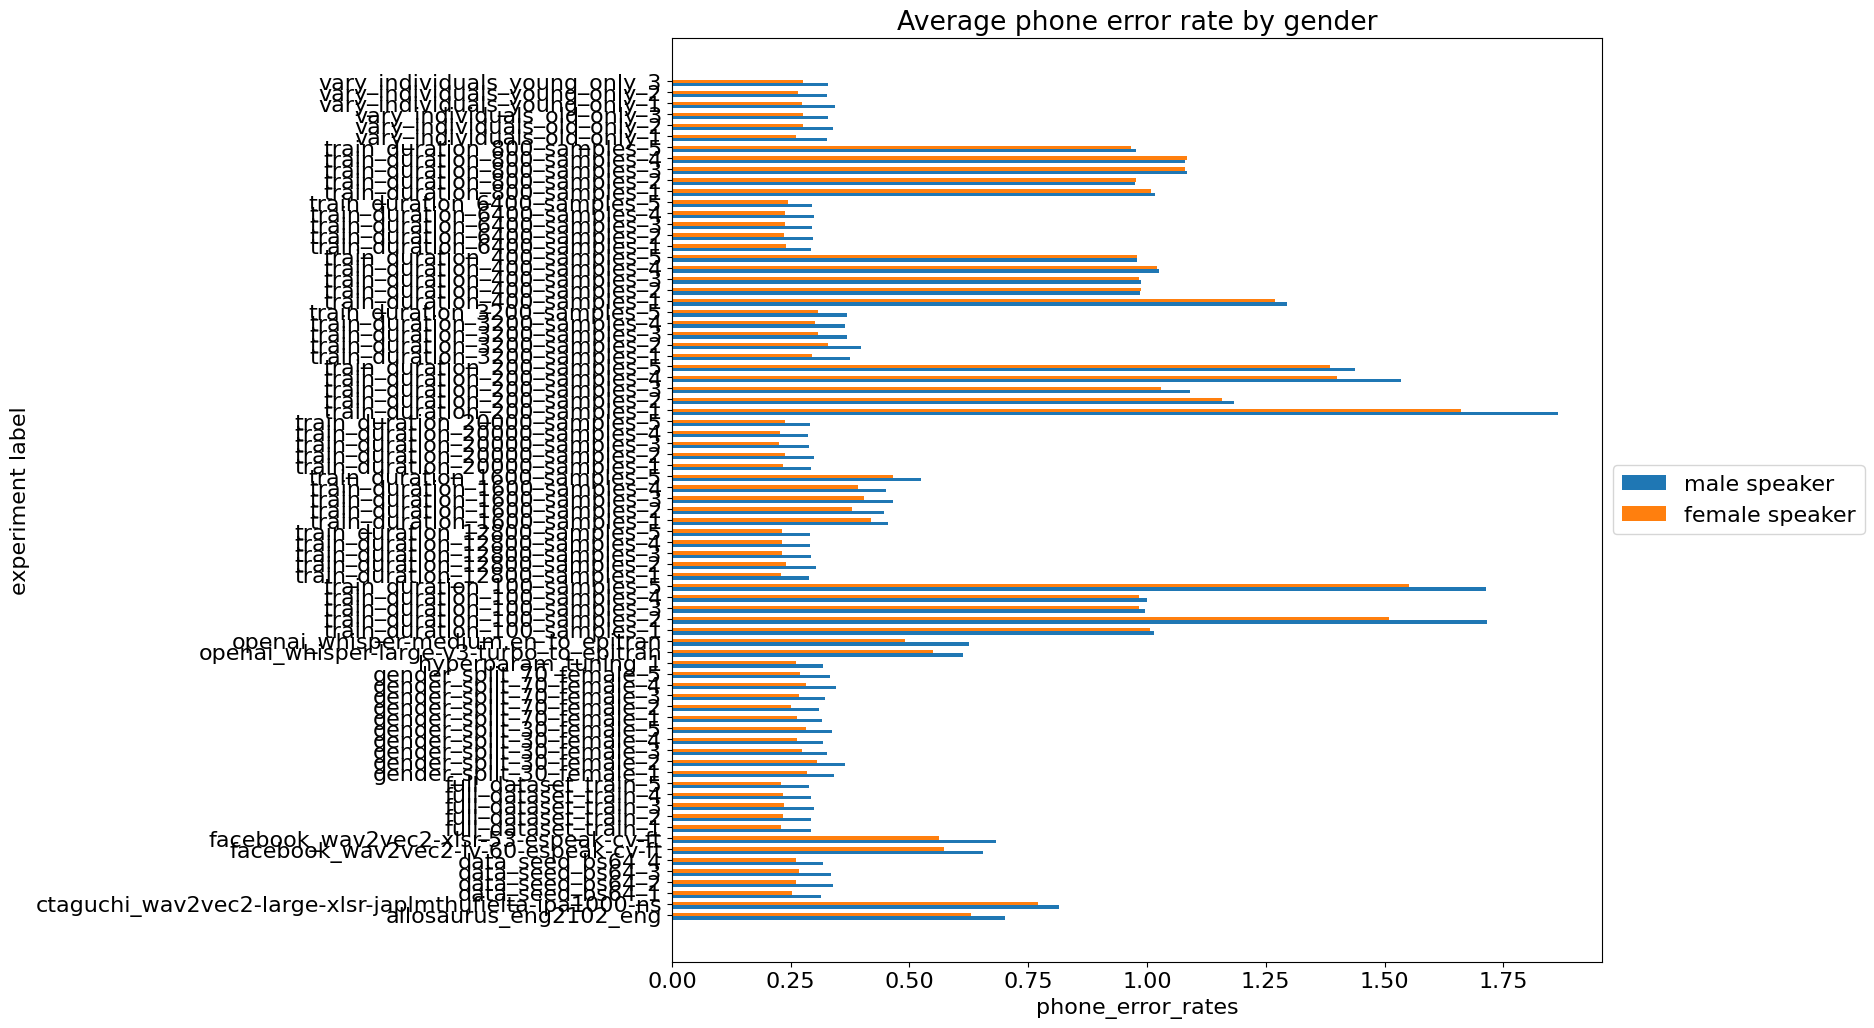

In [18]:
plot_binary_category_grouped_metrics(models, gendered_metrics['m'], gendered_metrics['f'])

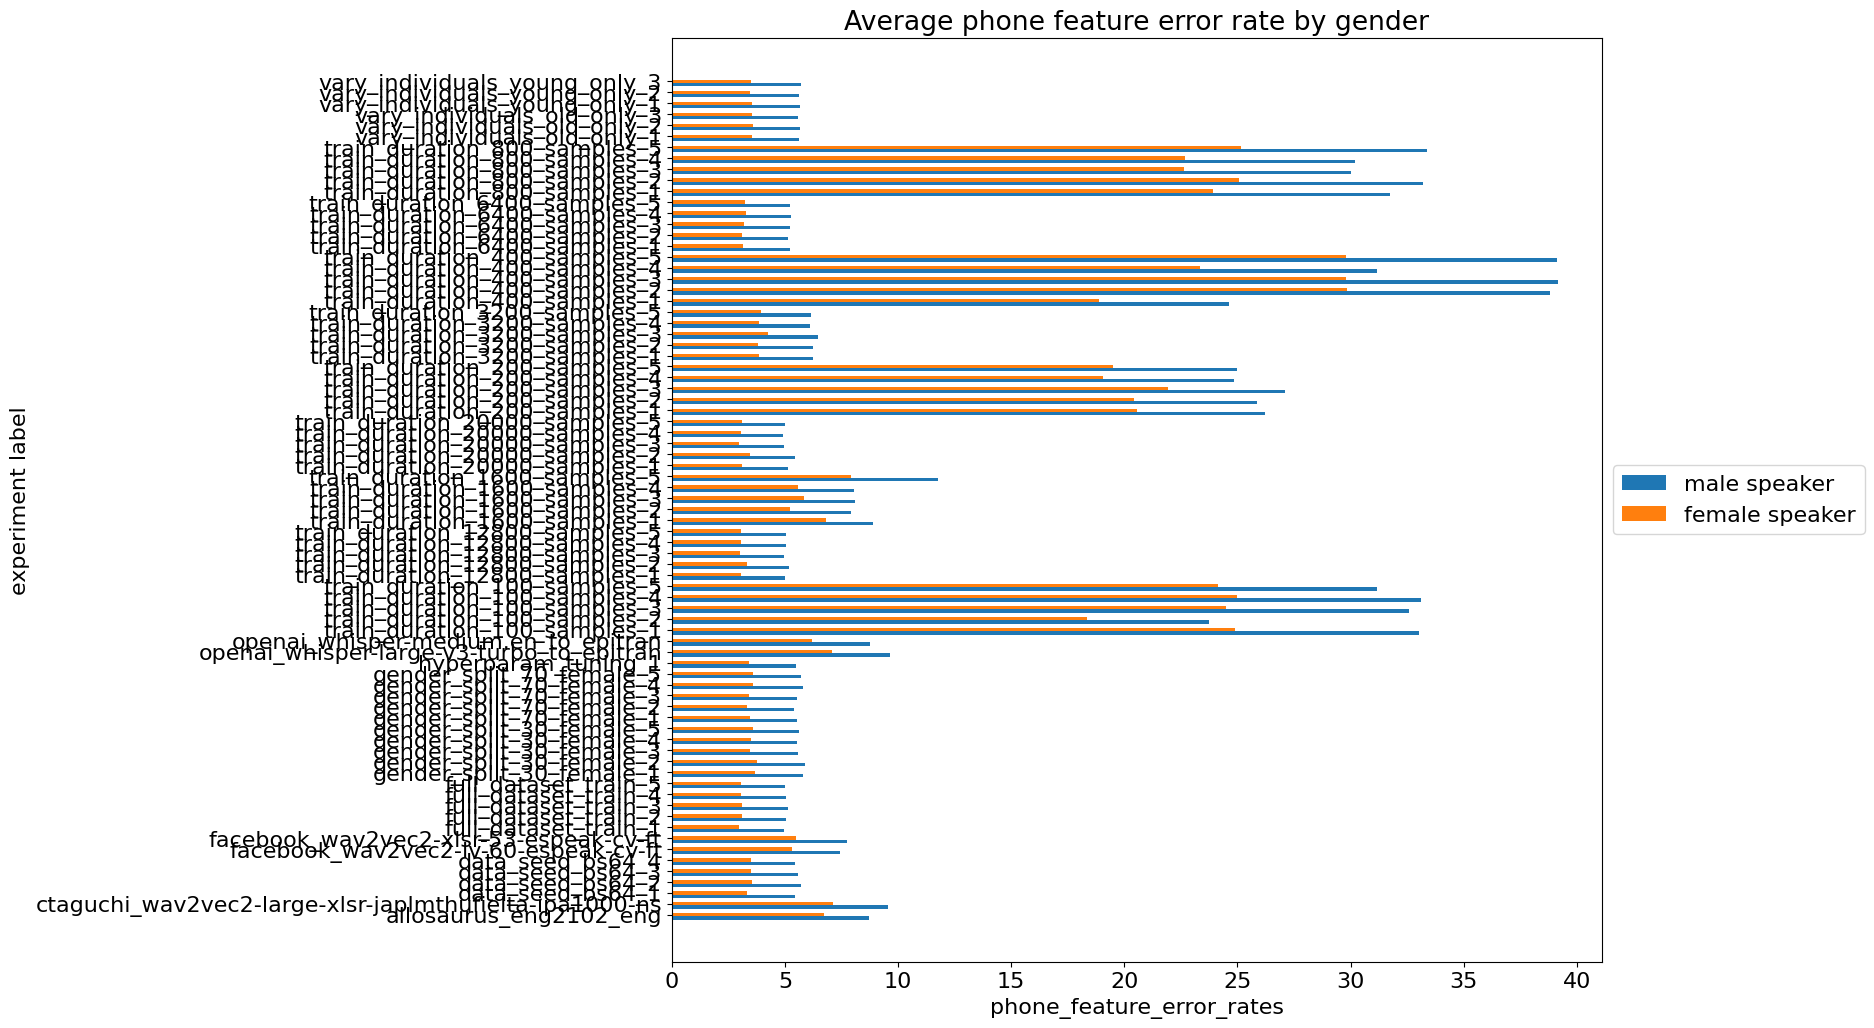

In [19]:
plot_binary_category_grouped_metrics(models, gendered_metrics['m'], gendered_metrics['f'], title="Average phone feature error rate by gender", metric_name="phone_feature_error_rates")

In [20]:
# Also consider training data duration
# Is gender duration correlated with performance?
trained_models = list()
male_metrics_trained_models = defaultdict(list)
female_metrics_trained_models = defaultdict(list)
female_speaker_duration = []
male_speaker_duration = []
for i, model in enumerate(models):
    model_folder = TRAINED_MODEL_PATH / model
    if model_folder.is_dir():
        trained_models.append(model_folder.name)
        for metric in ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]:
            male_metrics_trained_models[metric].append(gendered_metrics['m'][metric][i])
            female_metrics_trained_models[metric].append(gendered_metrics['f'][metric][i])

        with open(model_folder / "final_evaluation.json") as model_eval:
            model_eval_dict = json.load(model_eval)
            female_speaker_duration.append(model_eval_dict["train_duration_female_examples"])
            male_speaker_duration.append(model_eval_dict["train_duration_male_examples"])

print("Trained models:", trained_models)
print("Sanity check metrics from female speakers:", female_metrics_trained_models)

Trained models: []
Sanity check metrics from female speakers: defaultdict(<class 'list'>, {})


In [21]:
def scatter_plot_gender_duration_metric(male_metrics, female_metrics, male_duration, female_duration, title, metric):
    fig, ax = plt.subplots()
    for x, y, color, label in [(male_duration, male_metrics[metric],'tab:blue', "male speaker"),
                                (female_duration, female_metrics[metric], 'tab:orange', "female speaker")]:
        ax.scatter(x, y, c=color, label=label)
    if metric=="phone_error_rates":
        plt.ylim([0,0.4])
    elif metric=="phone_feature_error_rates":
        plt.ylim([0, 6.5])
    plt.ylabel(metric)
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

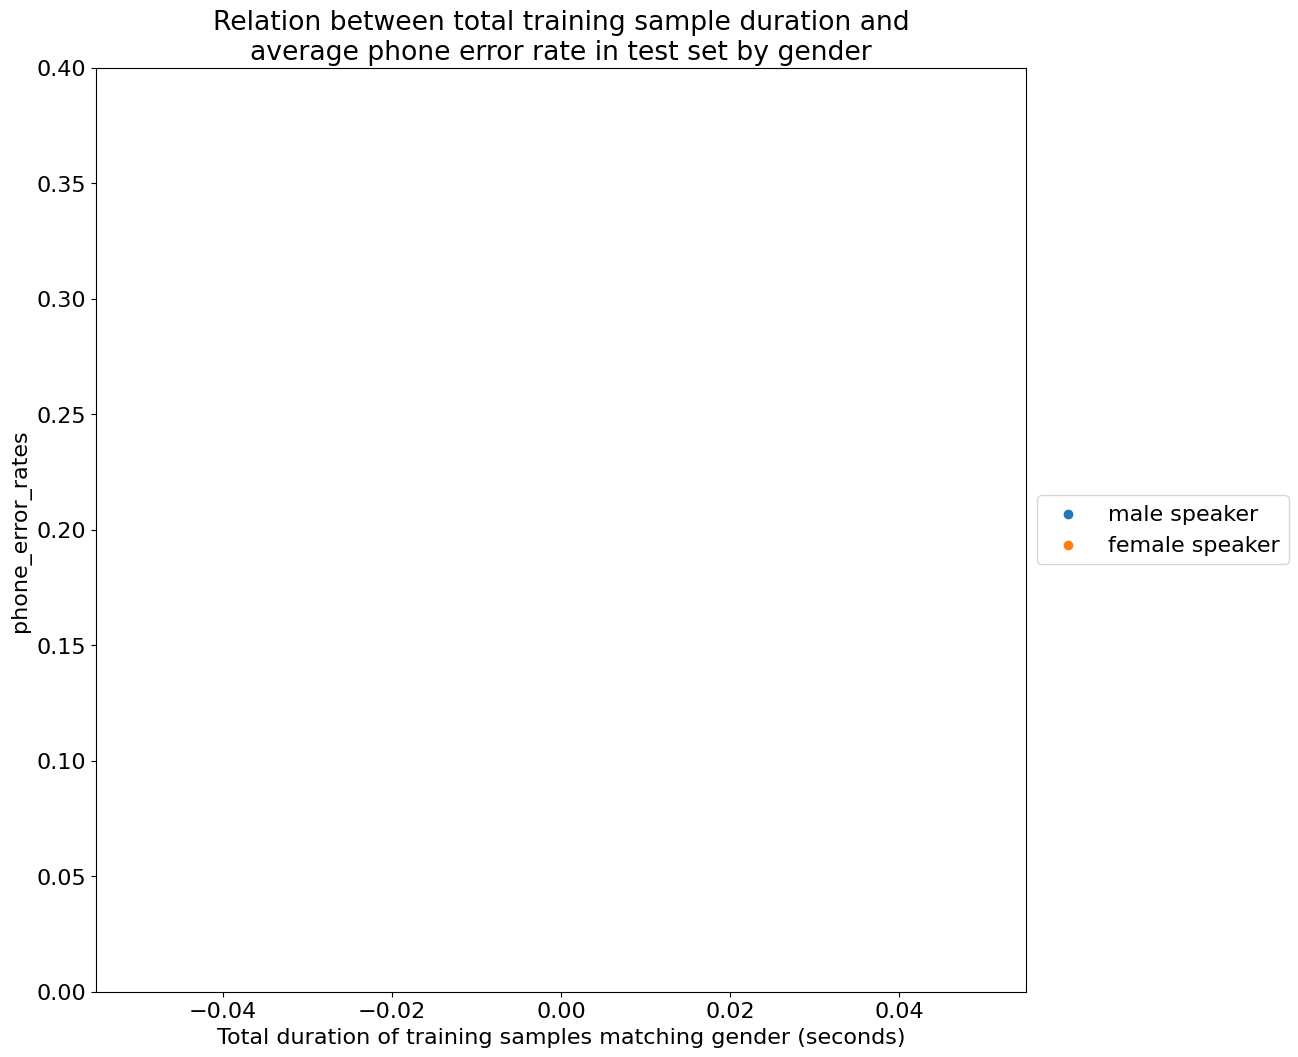

In [22]:
scatter_plot_gender_duration_metric(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

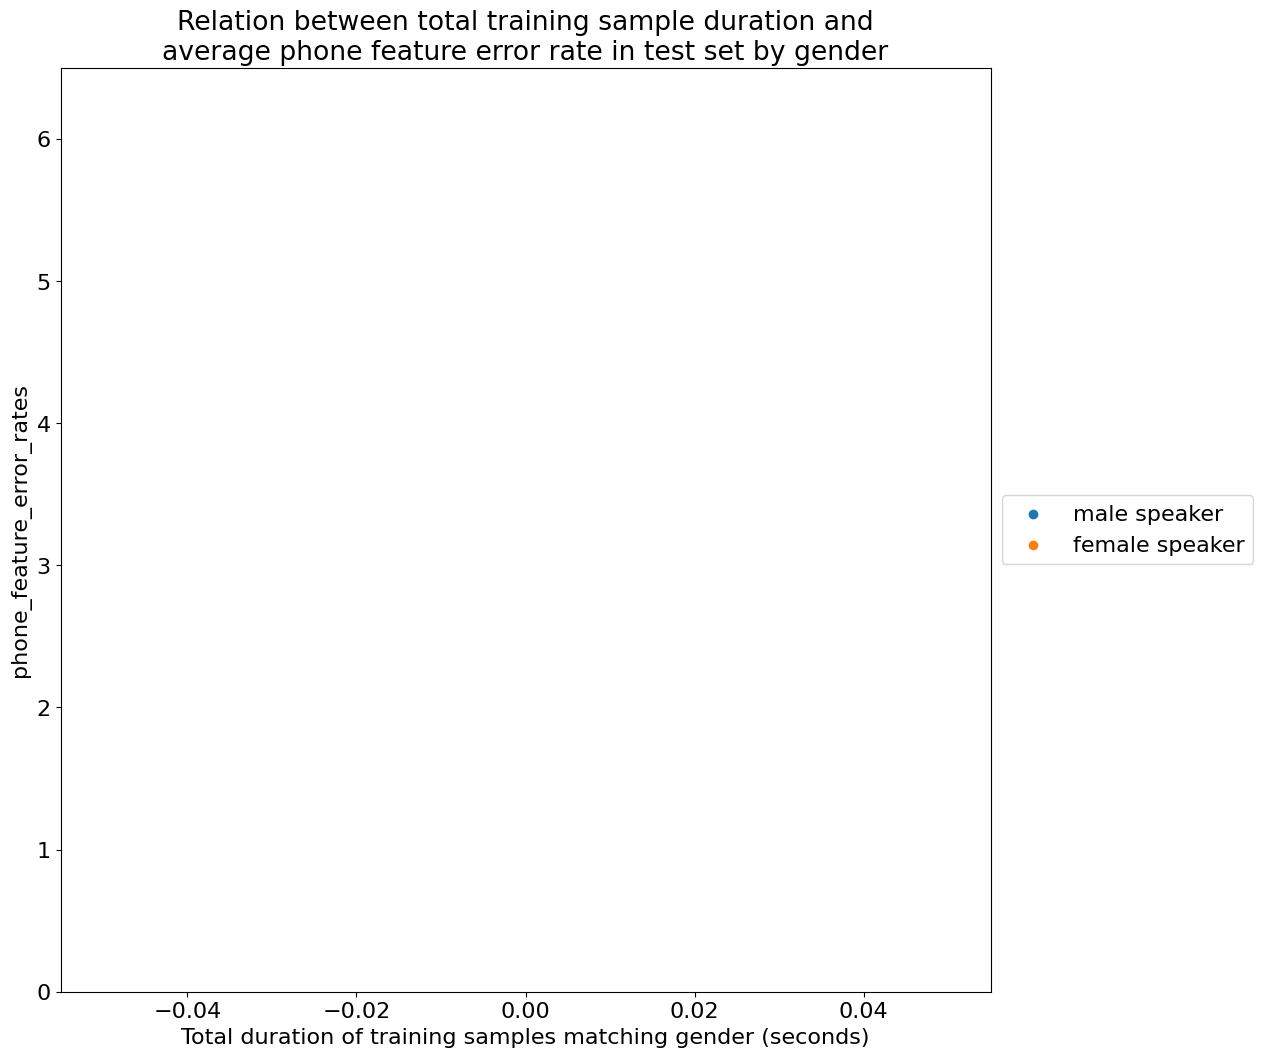

In [23]:
scatter_plot_gender_duration_metric(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender", "phone_feature_error_rates")

In [24]:
def scatter_plot_model_breakdown(male_metrics, female_metrics, male_duration, female_duration, models, title, metric):
    model_groups = set([m[:-2] for m in models])
    colors = sns.hls_palette(len(model_groups))

    color_map = dict(zip(model_groups, colors))

    fig, ax = plt.subplots(figsize=(12,8), layout="constrained")
    lines_for_legend = []
    labels_for_legend = []
    for i, model in enumerate(models):
        model_group = model[:-2]
        color = color_map[model_group]
        male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model_group)
        legend_line = ax.scatter(female_duration[i], female_metrics[metric][i], c=color, label=model_group)
        if model_group not in labels_for_legend:
            lines_for_legend.append(legend_line)
            labels_for_legend.append(model_group)

    if metric=="phone_error_rates":
        plt.ylim([0,0.4])
        plt.ylabel("Average Phone Error Rate")
    elif metric=="phone_feature_error_rates":
        plt.ylim([0, 6.5])
        plt.ylabel("Average Phone Feature Error Rate")
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    # Add model groups to legend
    fig.legend(handles=lines_for_legend, bbox_to_anchor=(1.35, 0.5)) #loc='outside right upper')
    # Add gender groups to legend
    fig.legend([male_line, legend_line], ["male speaker", "female speaker"], bbox_to_anchor=(1.25, 0.7)) #loc="outside right center")


UnboundLocalError: cannot access local variable 'male_line' where it is not associated with a value

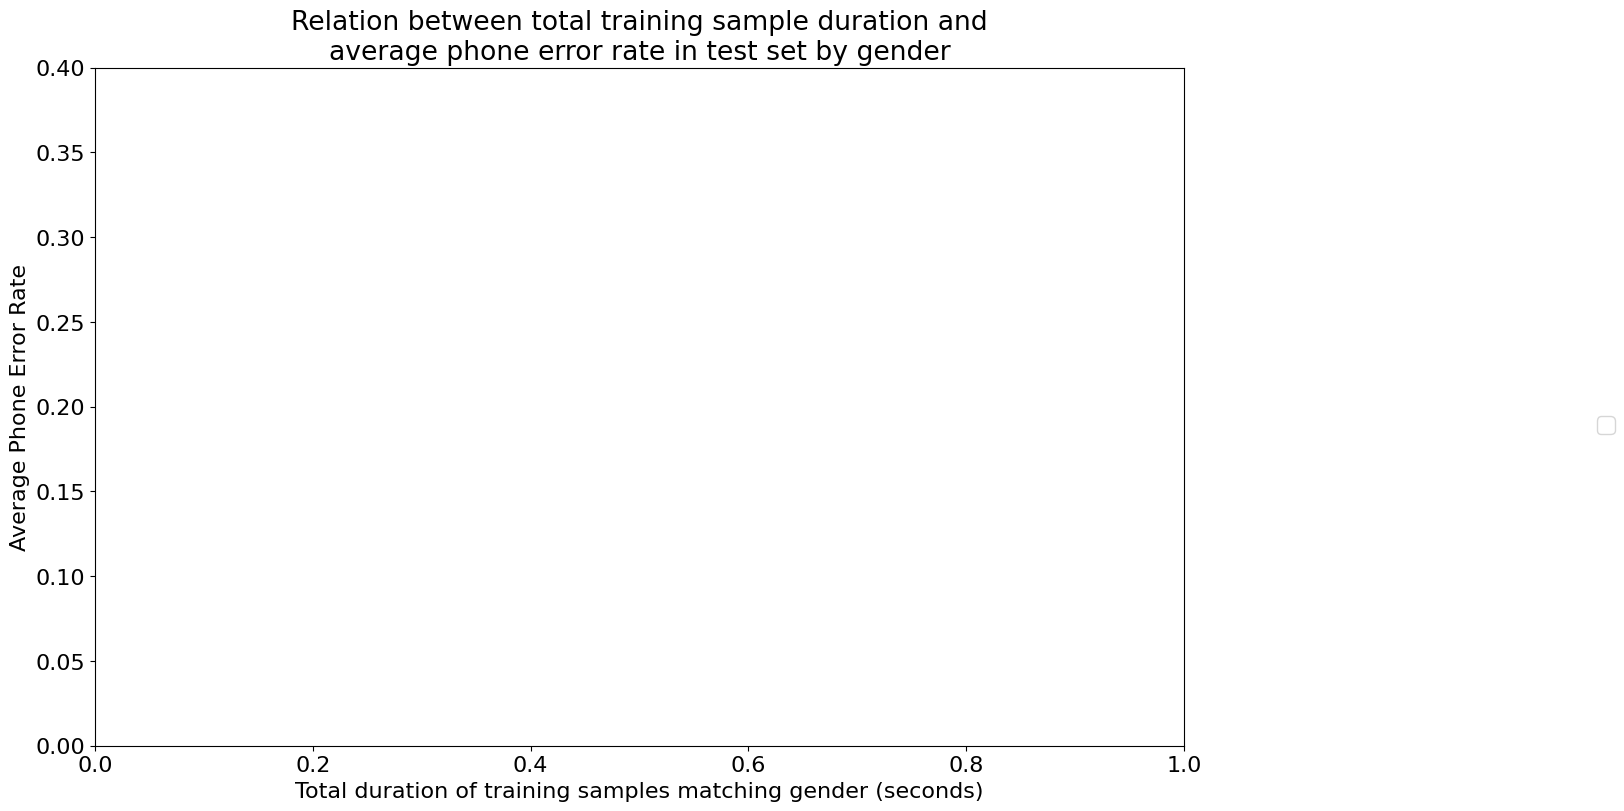

In [25]:
scatter_plot_model_breakdown(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration, trained_models,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

In [ ]:
scatter_plot_model_breakdown(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration, trained_models,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender", "phone_feature_error_rates")

# Differences in performance by speaker age group
All the models had better performance (lower error rates) for speakers older than 40 compared to speakers younger than 30 in the test set. This is true even in the 'vary_individuals_old_only' and 'vary_individuals_young_only' models, where only speakers from one age group were allowed to appear in the training data. This does not hold for external models, where there is very little difference between performance on older and younger speakers and in some cases performance is better on younger speakers (i.e. the Taguchi and Whisper medium English models).

Again, it's not clear whether these differences are statistically significant, although they do seem systematic. 

In [ ]:
age_groups_metrics, models = stratify_mean_by_experiment_group_and_demographic(all_data, demo_key="speaker_age_range")
print(age_groups_metrics)
print(models)

In [ ]:
# Check that these are all the same length to make sure we parsed data correctly
assert len(age_groups_metrics['o']['phone_error_rates']) == len(age_groups_metrics['y']['phone_error_rates'])
assert len(age_groups_metrics['y']['phone_error_rates']) == len(models)

In [ ]:
plot_binary_category_grouped_metrics(models, age_groups_metrics['o'], age_groups_metrics['y'], title="Average phone error rate by age group",
    category1_label="older than 40", category2_label="younger than 30")

In [ ]:
plot_binary_category_grouped_metrics(models, age_groups_metrics['o'], age_groups_metrics['y'], title="Average phone feature error rate by age group",
    category1_label="older than 40", category2_label="younger than 30", metric_name="phone_feature_error_rates")